# Change the paths with yours

In [1]:

%load_ext autoreload
%autoreload 2

from ctapipe.io import event_source
import sys
 
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
import sys
from scipy.stats import norm
from traitlets.config.loader import Config 
from ctapipe import utils

# ctapipe modules
from ctapipe.visualization import CameraDisplay
from ctapipe.plotting.camera import CameraPlotter
from ctapipe.image.extractor import *
from ctapipe.io.containers import PedestalContainer
from ctapipe.io.hdf5tableio import HDF5TableWriter, HDF5TableReader
from lstchain.calib.camera.r0 import LSTR0Corrections
from lstchain.calib.camera.calibrator import LSTCameraCalibrator


tel_id=1 



# r0 to r1 calibrator
r0_r1_calibrator = LSTR0Corrections(
    pedestal_path="/ctadata/franca/fefs/aswg/real//calibration/20191124/v00/drs4_pedestal.Run1623.0000.fits",
    r1_sample_start=2,r1_sample_end=38, tel_id=tel_id)

# r1 to dl1 calibrator
inp="/ctadata/franca/fefs/aswg/real//calibration/20191124/v00/calibration.Run1625.0000.hdf5"
time_calib = "/ctadata/franca/fefs/aswg/real/calibration/20191124/v00/time_calibration.Run1625.0000.hdf5"
charge_config = Config({
    "LocalPeakWindowSum": {
        "window_shift": 5,
        "window_width": 12 
    }
})

r1_dl1_calibrator = LSTCameraCalibrator(calibration_path = inp,
                               time_calibration_path = time_calib,
                               gain_threshold = 3000,
                               image_extractor="LocalPeakWindowSum",
                               config=charge_config)

# shower events
run =1626
file = f'/ctadata/franca/fefs/aswg/real/R0/20191124/LST-1.1.Run01626.0000.fits.fz'
reader = event_source(file, max_events=None)

print(f"\n Read {len(reader.multi_file)} total events  in files\n")
print(f"{reader.file_list} ")


 Read 53000 total events  in files

['/ctadata/franca/fefs/aswg/real/R0/20191124/LST-1.1.Run01626.0000.fits.fz', '/ctadata/franca/fefs/aswg/real/R0/20191124/LST-1.2.Run01626.0000.fits.fz', '/ctadata/franca/fefs/aswg/real/R0/20191124/LST-1.3.Run01626.0000.fits.fz', '/ctadata/franca/fefs/aswg/real/R0/20191124/LST-1.4.Run01626.0000.fits.fz'] 


In [2]:
# function to plot charge and time

def plot_charge_time():
    
    dim = event.dl1.tel[tel_id].image.ndim
    #dim = event.dl1.tel[tel_id].image.ndim
    if dim == 1:
        fig = plt.figure(figsize=(16, 8))
        pad = 120
        mask=np.where(event.lst.tel[tel_id].evt.pixel_status>0)
    else:
        fig = plt.figure(figsize=(16, 16))
        pad = 220
        mask =[]


    for chan in np.arange(dim):
        if dim == 1:
            image = event.dl1.tel[tel_id].image
        else:   
            image = event.dl1.tel[tel_id].image[chan]

        pad+=1
        ax = plt.subplot(pad)
        plt.tight_layout()
        disp = CameraDisplay(event.inst.subarray.tels[tel_id].camera)
        disp.image = image  
        disp.cmap = plt.cm.coolwarm
        disp.set_limits_minmax(0,200)
        disp.axes.text(1.8, 0, f'charge (pe)', rotation=90)
        disp.add_colorbar()
        plt.tight_layout()
        print(f"charge : mean {image.mean()} +- {image.std()}")
        disp.highlight_pixels(mask,linewidth=2)

        pad+=1  
        if dim == 1:
            image = event.dl1.tel[tel_id].pulse_time 
        else:   
            image = event.dl1.tel[tel_id].pulse_time[chan]

        ax = plt.subplot(pad)  
        plt.tight_layout()
        disp = CameraDisplay(event.inst.subarray.tels[tel_id].camera)
        disp.image = image 
        disp.highlight_pixels(mask,linewidth=2)
        disp.set_limits_minmax(-10,10)
        disp.cmap = plt.cm.coolwarm
        disp.axes.text(1.8, 0, f' time (ns)', rotation=90)
        disp.add_colorbar()
        plt.tight_layout()
        print(f"time: mean {image.mean()} +- {image.std()}")


# No gain selection

max pe 220.01036115245046
read event id: 941, trigger 1
charge : mean 2.2723952365351874 +- 10.487672422738001
time: mean -47914998806514.086 +- 2063128823681183.2
charge : mean 3.774475510352069 +- 11.255669958471351
time: mean -16166301963796.297 +- 696090251165452.4


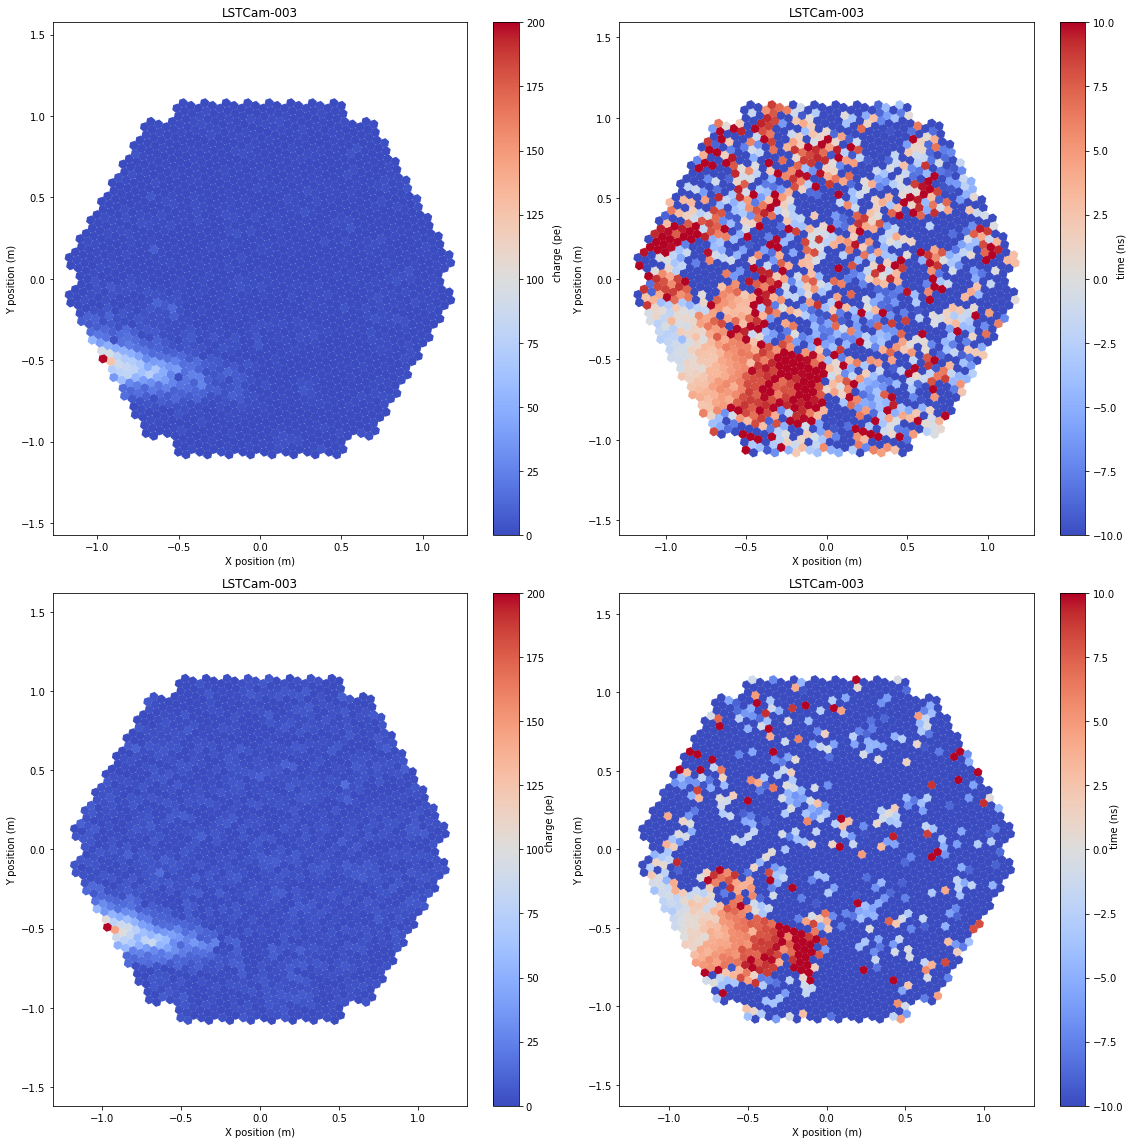

In [4]:
# loop on events
r1_dl1_calibrator = LSTCameraCalibrator(calibration_path = inp,
                               time_calibration_path = time_calib,
                               gain_threshold = None,
                               image_extractor="LocalPeakWindowSum",
                               config=charge_config)

for i, event in enumerate(reader):
    
    if event.r0.event_id%500 == 0:
        print(event.r0.event_id)
              
    # calibrate r0 --> r1        
    r0_r1_calibrator.calibrate(event)
   
    # if triggerd event
    if event.r0.tel[tel_id].trigger_type != 32:                   
        
        # calibrate r1 --> dl1
        r1_dl1_calibrator(event)
        image = event.dl1.tel[tel_id].image
        mask=np.where(event.lst.tel[tel_id].evt.pixel_status>0)
        # select image with bright event and stop
        if np.max(image>200):             
            print(f"max pe {np.max(image)}")
            break
            
            
print(f"read event id: {event.r0.event_id}, trigger {event.r0.tel[tel_id].trigger_type}")

# plot selected event
plot_charge_time()

# with gain selection

500
max pe 299.6918974363638
read event id: 872, trigger 1
charge : mean 5.059062775352811 +- 22.81275403959286
time: mean -6.734562814536104 +- 15.975402810668552


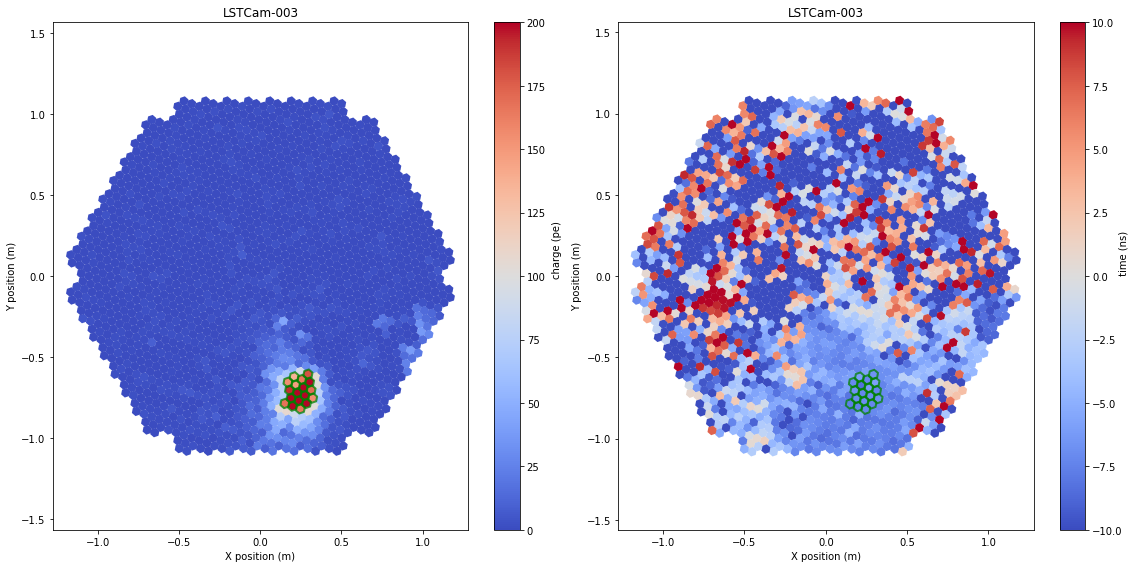

In [3]:
# loop on events
r1_dl1_calibrator = LSTCameraCalibrator(calibration_path = inp,
                               time_calibration_path = time_calib,
                               gain_threshold = 3000,
                               image_extractor="LocalPeakWindowSum",
                               config=charge_config)

for i, event in enumerate(reader):
    
    if event.r0.event_id%500 == 0:
        print(event.r0.event_id)
              
    # calibrate r0 --> r1        
    r0_r1_calibrator.calibrate(event)
   
    # if triggerd event
    if event.r0.tel[tel_id].trigger_type != 32:                   
        
        # calibrate r1 --> dl1
        r1_dl1_calibrator(event)
        image = event.dl1.tel[tel_id].image
        mask=np.where(event.lst.tel[tel_id].evt.pixel_status>0)
        # select image with bright event and stop
        if(np.max(image>200) and len(mask[0])>1):             
            print(f"max pe {np.max(image)}")
            break
            
            
print(f"read event id: {event.r0.event_id}, trigger {event.r0.tel[tel_id].trigger_type}")

# plot selected event
plot_charge_time()